In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
!gdown 1w0TorBfTIqbquQVd6k3h_77ypnrvfGwf
!unzip -q SCUT-FBP5500_v2.1.zip
# !unzip -q '/content/drive/MyDrive/!КУРСАЧ/SCUT/SCUT-FBP5500_v2.1.zip'
# !unzip -q '/content/drive/MyDrive/!КУРСАЧ/SCUT/scut-fbp_dataset/Data_Collection.zip'
# !unzip -q '/content/drive/MyDrive/!КУРСАЧ/SCUT/scut-fbp_dataset/Rating_Collection.zip'

Downloading...
From: https://drive.google.com/uc?id=1w0TorBfTIqbquQVd6k3h_77ypnrvfGwf
To: /content/SCUT-FBP5500_v2.1.zip
100% 180M/180M [00:02<00:00, 85.7MB/s]


In [ ]:
from scipy.spatial import distance
from imutils import face_utils
from google.colab.patches import cv2_imshow
import imutils
import dlib
import cv2
import string
import urllib.request
import random

import math
urllib.request.urlretrieve("https://raw.githubusercontent.com/tzutalin/dlib-android/master/data/shape_predictor_68_face_landmarks.dat", "shape_predictor_68_face_landmarks.dat")

('shape_predictor_68_face_landmarks.dat',
 <http.client.HTTPMessage at 0x7fd32531b220>)

In [ ]:
import torch.optim as optim
import torchvision
import copy
import numpy as np
import torch
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import models
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import os
import torch, gc
import time
import os
import torch.nn as nn
from PIL import Image, ImageOps
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from IPython.display import clear_output
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Helping functions

In [ ]:
def train_and_validate(model, optimizer, criterion, train_loader, val_loader, n_epochs):
    train_loss_log, val_loss_log, train_metrics_log, val_metrics_log = [], [], [], []
    best_pc = 0
    best_model = copy.deepcopy(model.state_dict())
    for epoch in tqdm(range(n_epochs)):
        running_loss = 0
        targets_array, outputs_array = [], []
        model.train()
        for img, target in train_loader:
            ###########code from seminar###########
            img = img.to(device)
            target = target.to(device)
            target = target.squeeze(1)
            optimizer.zero_grad()
            outputs = model(img).view(-1)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            ############################
            running_loss += loss.item() * img.shape[0]
            targets_array += target.to('cpu').detach().numpy().ravel().tolist()
            outputs_array += outputs.to('cpu').detach().numpy().ravel().tolist()

        cur_mae = mean_absolute_error(np.array(targets_array).flatten(), np.array(outputs_array).flatten())
        train_loss_log += [running_loss / len(train_loader.dataset)]
        train_metrics_log += [cur_mae]

        model.eval()
        running_loss = 0
        y_pred = []
        y_true = []
        for img, target in val_loader:
            with torch.no_grad():
                img = img.to(device)
                target = target.to(device)
                target = target.squeeze(1)
                outputs = model(img).view(-1)
                loss = criterion(outputs, target)
                y_pred += outputs.to("cpu").detach().numpy().ravel().tolist()
                y_true += target.to("cpu").detach().numpy().ravel().tolist()
                running_loss += loss.item() * img.shape[0]
        ############################
        val_loss_log += [running_loss / len(val_loader.dataset)]
        mae = mean_absolute_error(y_true, y_pred)
        pc = np.corrcoef(y_true, y_pred)[0, 1]
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        if pc > best_pc:
            best_pc = pc
            best_model = copy.deepcopy(model.state_dict())
            model.load_state_dict(best_model)
            torch.save({
            'model_state_dict': model.state_dict(),
            'pc': pc,
            'mae': mae,
            "rmse": rmse
            }, '/content/model/Epoch-{}.pth'.format(epoch))
        val_metrics_log += [mae]
        plot_losses(train_loss_log, train_metrics_log, val_loss_log, val_metrics_log, "Metric")
        gc.collect()
        torch.cuda.empty_cache()
    return train_metrics_log, val_metrics_log

In [ ]:
def plot_losses(train_losses, train_metrics, val_losses, val_metrics, metric_name):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='Train')
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='Val')
    axs[1].plot(range(1, len(train_metrics) + 1), train_metrics, label='Train')
    axs[1].plot(range(1, len(val_metrics) + 1), val_metrics, label='Val')

    if max(train_losses) / min(train_losses) > 10:
        axs[0].set_yscale('log')

    if max(train_metrics) / min(train_metrics) > 10:
        axs[0].set_yscale('log')

    for ax in axs:
        ax.set_xlabel('Epoch')
        ax.legend()

    axs[0].set_ylabel('Loss')
    axs[1].set_ylabel(metric_name)
    plt.show()

## Data Sets

In [ ]:
class SCUTFBP5500Dataset(Dataset):
    def __init__(self, images_path, txt_path, transform = None):
        self.images_path = images_path
        self.txt_path = txt_path
        self.dataframe = pd.read_csv(txt_path, header = None, sep = ' ')
        self.dataframe = self.dataframe.rename(columns = {0: 'Image', 1: 'Score'})
        self.transform = transform

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.images_path, self.dataframe.Image[idx]))
        target = torch.Tensor([self.dataframe.Score[idx]])
        if self.transform:
            img = self.transform(img)
        return [img, target]

In [ ]:
class SCUTFBPDataset(Dataset):
    def __init__(self, images_path, txt_path, transform = None):
        self.images_path = images_path
        self.dataframe = pd.read_excel(txt_path)
        self.transform = transform

    def __len__(self):

        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.images_path, 'SCUT-FBP-%d.jpg' % self.dataframe['#Image'][idx]))
        target = torch.Tensor([self.dataframe['Attractiveness label'][idx]])
        if self.transform:
            img = self.transform(img)
        return [img, target]

## Regnet

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
regnet = models.regnet_y_8gf()
regnet.fc = nn.Linear(2016, 1, bias = True)
regnet = regnet.to(device)

In [ ]:
sum(p.numel() for p in regnet.parameters())

37366489

## Efficient Net

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
efficientnet_v2_s = models.efficientnet_v2_s()
efficientnet_v2_s.classifier[1] = nn.Linear(1280, 1, bias = True)
efficientnet_v2_s = efficientnet_v2_s.to(device)
# efficientnet_v2_s

In [ ]:
sum(p.numel() for p in efficientnet_v2_s.parameters())

20178769

## Dataloaders

In [ ]:
def Data_loader(BATCH_SIZE, dataset_name):
    transform_train = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.RandomRotation(30),
            transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 5)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    transform_test = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    if dataset_name == 'SCUT-FBP5500':
        source_path = '/content/SCUT-FBP5500_v2/Images'
        train_path = '/content/SCUT-FBP5500_v2/train_test_files/split_of_60%training and 40%testing/train.txt'
        test_path = '/content/SCUT-FBP5500_v2/train_test_files/split_of_60%training and 40%testing/test.txt'
        train_set = SCUTFBP5500Dataset(source_path, train_path, transform = transform_train)
        test_set = SCUTFBP5500Dataset(source_path, test_path, transform = transform_test)
        train_loader = torch.utils.data.DataLoader(train_set, batch_size = BATCH_SIZE, shuffle = True)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATCH_SIZE, shuffle = False)
    elif dataset_name == 'SCUT-FBP':
        source_path = '/content/Data_Collection'
        dataframe_path = '/content/Rating_Collection/Attractiveness label.xlsx'
        data_set = SCUTFBPDataset(source_path, dataframe_path, transform = transform_test)
        train_set, test_set = train_test_split(data_set, test_size = 0.4, random_state = 42)
        train_loader = torch.utils.data.DataLoader(train_set, batch_size = BATCH_SIZE, shuffle = True)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATCH_SIZE, shuffle = False)
    return (train_loader, test_loader)

In [ ]:
BATCH_SIZE = 32
NUM_EPOCHS = 70

## Train

In [ ]:
train_loader_5500, test_loader_5500 = Data_loader(BATCH_SIZE, 'SCUT-FBP5500')

#### EFFICEINTNETV2 TRAINING PROCESS

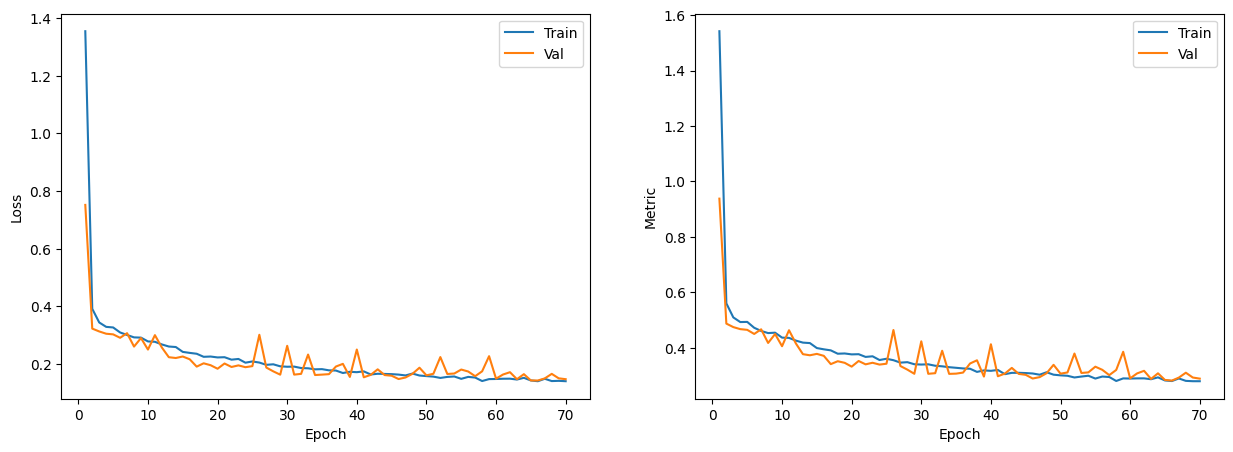

In [ ]:
!rm -r 'model'
!mkdir 'model'
criterion = nn.SmoothL1Loss(beta=0.4)
optimizer_efficient = torch.optim.Adam(efficientnet_v2_s.parameters(), lr=1e-4, weight_decay=1e-3)
train_metrics_log_2, val_metrics_log_2 = train_and_validate(efficientnet_v2_s, optimizer_efficient, criterion, train_loader_5500, test_loader_5500, NUM_EPOCHS)

In [ ]:
checkpoint = torch.load('/content/model/Epoch-59.pth')
checkpoint['pc'], checkpoint['mae'], checkpoint['rmse']

(0.8461659303827285, 0.28982091128826143, 0.3794299035960452)

#### REGNET TRAINING PROCESS

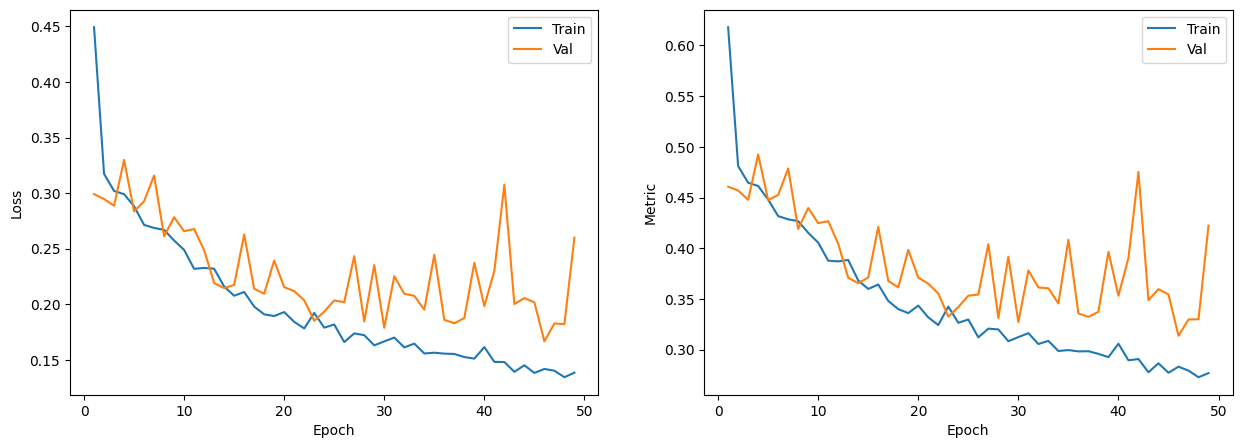

In [ ]:
%%time
!rm -r 'model'
!mkdir 'model'
criterion = nn.SmoothL1Loss(beta=0.4)
optimizer_reg = torch.optim.Adam(regnet.parameters(), lr=1e-4, weight_decay=1e-3)
train_metrics_log_2, val_metrics_log_2 = train_and_validate(regnet, optimizer_reg, criterion, train_loader_5500, test_loader_5500, NUM_EPOCHS)